# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №4

## №1 (40 баллов)

- Вам дан файлик `HW_004_001.csv`
- В нем находится одномерный временной ряд
- Ваша задача подобрать лучшую модель, которая бы описывала эти данные

- Начнем с чего простого. Загрузим данные

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.datasets import longley
from statsmodels.formula.api import ols

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

from statsmodels.tsa.ar_model import ar_select_order

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# инициализируем plotly
init_notebook_mode(connected = True)

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [35]:
import warnings
warnings.filterwarnings("ignore")


In [11]:
df = pd.read_csv('HW_004_001.csv') 

In [12]:
df.head()

date         y
0  2018-07-18  0.101160
1  2018-07-19  0.622773
2  2018-07-20 -0.796028
3  2018-07-21  3.154209
4  2018-07-22  1.800747

- Нарисуем данные

In [14]:
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Text(0, 0.5, 'y')

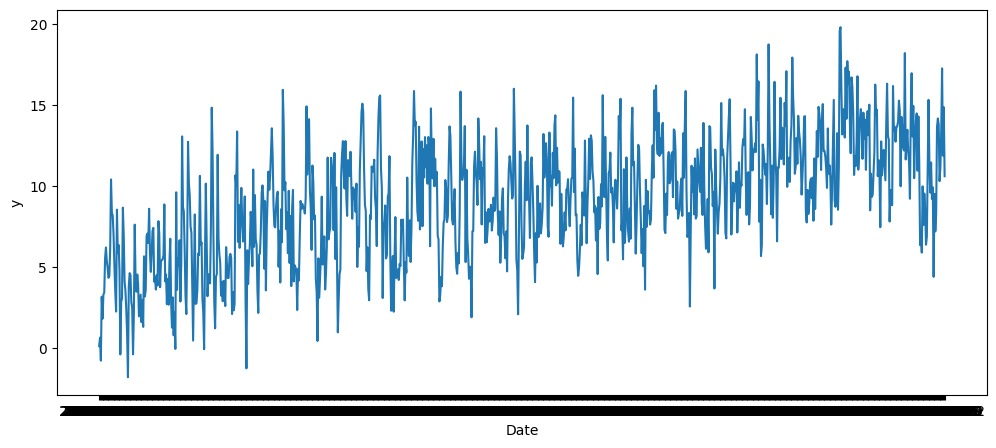

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['y'])
plt.xlabel('Date')
plt.ylabel('y')

In [17]:
plotly_df(df.set_index('date'), title = 'TimeSeries')

- Можно ли что-то сказать про данные судя по графику?

Если смотреть глобально, то есть восходящий тренд, и если смотреть отдельно близко, то как будто есть недельная периодичность

- Нарисует `ACF()`, `PACF()`

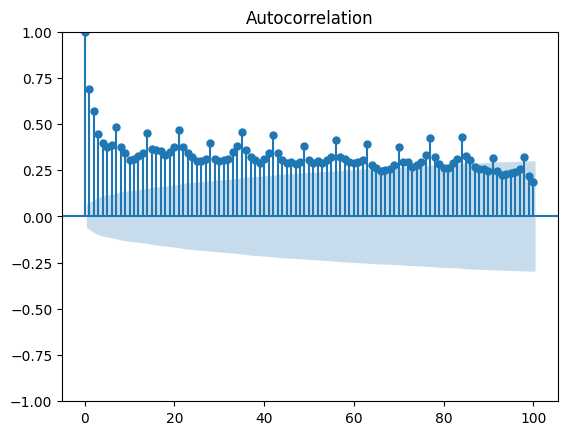

In [23]:
plot_acf(np.array(df.y), lags=100)
plt.show()

C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



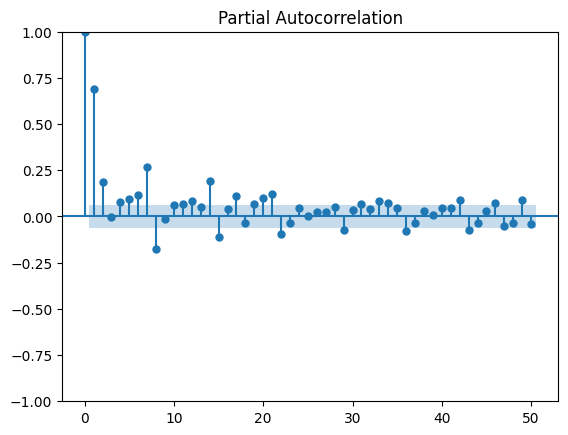

In [22]:
plot_pacf(np.array(df.y), lags=50)
plt.show()

- Можно ли сделать какой-то вывод?

Автокорреляция очевидно есть, наверное счамый значимый лаг - первый, остальные можно не учесть пока что. По ACF я готов предположить, что это не только AR(1) процесс, часть с MA имеется. Это ARMA

- Ну а теперь ваша свобода 
- Продолжите анализ
    - Не забывайте про стационарность
    - А как насчет тренда?
    - Есть ли сезонность?
    - Может быть в [документации](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) будут еще полезные трюки
    - А может быть будет что-то полезное в [учебнике](https://otexts.com/fpp2/)

Проверим тестами на стационарность

In [25]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [26]:
adf_test(df['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.657991
p-value                          0.081594
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [27]:
kpss_test(df['y'])

Results of KPSS Test:
Test Statistic            4.263181
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Оба теста говорят нам о нестационарности ряда

In [28]:
delta_index = (df.y - df.y.shift()).dropna()
adf_test(delta_index)

Results of Dickey-Fuller Test:
Test Statistic                -1.110450e+01
p-value                        3.792430e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


In [29]:
kpss_test(delta_index)

Results of KPSS Test:
Test Statistic            0.120416
p-value                   0.100000
Lags Used                96.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Оба теста говорят, что теперь ряд стационарен

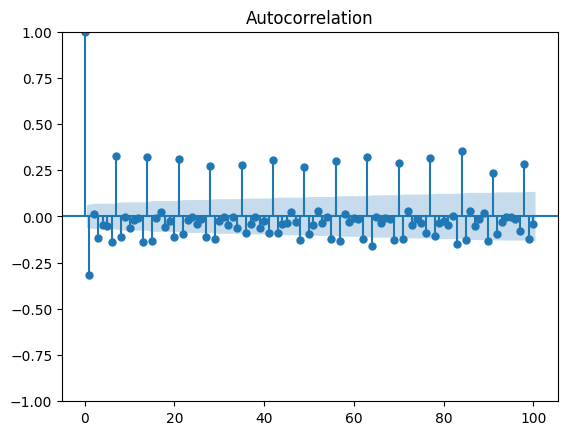

In [30]:
plot_acf(np.array(delta_index), lags=100)
plt.show()

C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



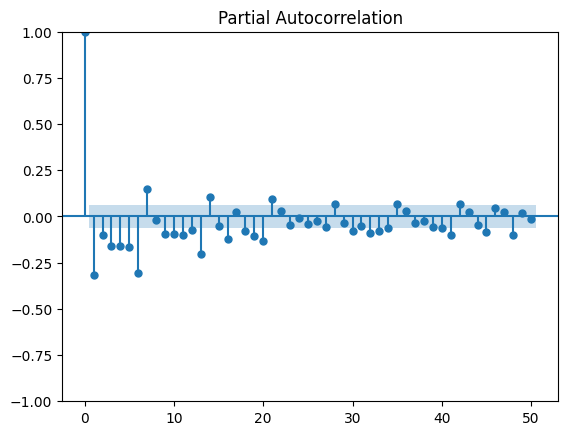

In [31]:
plot_pacf(np.array(delta_index), lags=50)
plt.show()

In [33]:
ar_select_order(delta_index, maxlag=10).ar_lags

C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\lubin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



[1, 2, 3, 4, 5, 6, 7]

Рекомендуется AR(7), посмотрим на MA часть

In [42]:
q = 15
tmp = np.empty(q)
for i in tqdm(range(q)):
    tmp[i] = ARIMA(delta_index, order = (7, 0, i)).fit().aic
best_q = np.argmin(tmp)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.19s/it]


In [43]:
tmp, best_q

(array([4672.1979416 , 4674.01933451, 4673.51295785, 4576.84275171,
        4571.28328694, 4593.4704981 , 4555.07336835, 4471.70909856,
        4558.00881212, 4463.9659719 , 4471.35967821, 4448.55543745,
        4451.0637765 , 4449.41261239, 4462.71857623]),
 11)

In [44]:
best_arima = ARIMA(delta_index, order = (7, 0, best_q)).fit()
print(best_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                ARIMA(7, 0, 11)   Log Likelihood               -2204.278
Date:                Fri, 14 Apr 2023   AIC                           4448.555
Time:                        12:21:45   BIC                           4546.691
Sample:                             0   HQIC                          4485.855
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.001      8.882      0.000       0.006       0.010
ar.L1         -0.1942      0.102     -1.896      0.058      -0.395       0.007
ar.L2         -0.1945      0.103     -1.882      0.0

Видим, что очень много незначимых лагов

Посмотрим на SARIMA модель, все-таки сезонность выкидывать из виду нехорошо.

In [45]:
best_arima_2 = ARIMA(delta_index, order = ((1, 0, 0, 0, 0, 0, 1), 0, (1, 0, 0, 1, 0, 0, 1, 1))).fit()
print(best_arima_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  999
Model:             ARIMA([1, 7], 0, [1, 4, 7, 8])   Log Likelihood               -2257.354
Date:                            Fri, 14 Apr 2023   AIC                           4530.708
Time:                                    12:35:44   BIC                           4569.962
Sample:                                         0   HQIC                          4545.628
                                            - 999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.046      0.215      0.830      -0.081       0.101
ar.L1         -0.0002      0.000   

Поиграемся с Prophet

In [50]:
df.columns = ['ds', 'y']

In [51]:
df.head()

ds         y
0  2018-07-18  0.101160
1  2018-07-19  0.622773
2  2018-07-20 -0.796028
3  2018-07-21  3.154209
4  2018-07-22  1.800747

In [52]:
def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')
df['ds']=df.ds.apply(date_converter)

Оставим 14 дней на прогноз

In [54]:
period = 14
end_date = max(df.ds) - datetime.timedelta(days=period)

In [60]:
data = df[df.ds <= end_date]
data_evaluation = df

In [62]:
data

ds          y
0   2018-07-18   0.101160
1   2018-07-19   0.622773
2   2018-07-20  -0.796028
3   2018-07-21   3.154209
4   2018-07-22   1.800747
..         ...        ...
981 2021-03-25  11.414633
982 2021-03-26   9.587024
983 2021-03-27  11.445283
984 2021-03-28   9.197777
985 2021-03-29   9.918506

[986 rows x 2 columns]

In [63]:
# 1. Создадим объект класса Prophet (все параметры модели задаются в конструкторе класса, используем дефолтные)
m = fp.Prophet()

# 2. Проведем обучение
m.fit(data)

# 3. Cоздадим таблицу с датами, охватывающими даты истории + "горизонт" для прогнозирования
future = m.make_future_dataframe(periods=period)

# 4. Получим предсказания на датах, полученных в предыдщуем шаге
forecast = m.predict(future)

In [64]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper   
0   2018-07-18   3.936912    2.116549    8.728053     3.936912     3.936912  \
1   2018-07-19   3.951350    0.199148    6.913932     3.951350     3.951350   
2   2018-07-20   3.965788    0.108931    6.686961     3.965788     3.965788   
3   2018-07-21   3.980227   -0.116632    6.286499     3.980227     3.980227   
4   2018-07-22   3.994665    0.075404    6.330808     3.994665     3.994665   
..         ...        ...         ...         ...          ...          ...   
995 2021-04-08  12.569057    8.789859   15.253099    12.569009    12.569278   
996 2021-04-09  12.575730    8.252726   14.542795    12.575585    12.576015   
997 2021-04-10  12.582403    7.569599   13.999089    12.582121    12.582869   
998 2021-04-11  12.589076    7.515919   13.916648    12.588537    12.589658   
999 2021-04-12  12.595750    6.869255   13.287868    12.595021    12.596523   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly   
0          1.307016              1.307016              1.307016  2.569104  \
1         -0.420749             -0.420749             -0.420749  0.581691   
2         -0.569768             -0.569768             -0.569768  0.165533   
3         -0.936610             -0.936610             -0.936610 -0.471606   
4         -0.826690             -0.826690             -0.826690 -0.630752   
..              ...                   ...                   ...       ...   
995       -0.659511             -0.659511             -0.659511  0.581691   
996       -1.129425             -1.129425             -1.129425  0.165533   
997       -1.811817             -1.811817             -1.811817 -0.471606   
998       -2.006014             -2.006014             -2.006014 -0.630752   
999       -2.421280             -2.421280             -2.421280 -1.022756   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper   
0        2.569104      2.569104 -1.262088     -1.262088     -1.262088  \
1        0.581691      0.581691 -1.002441     -1.002441     -1.002441   
2        0.165533      0.165533 -0.735302     -0.735302     -0.735302   
3       -0.471606     -0.471606 -0.465004     -0.465004     -0.465004   
4       -0.630752     -0.630752 -0.195938     -0.195938     -0.195938   
..            ...           ...       ...           ...           ...   
995      0.581691      0.581691 -1.241203     -1.241203     -1.241203   
996      0.165533      0.165533 -1.294959     -1.294959     -1.294959   
997     -0.471606     -0.471606 -1.340211     -1.340211     -1.340211   
998     -0.630752     -0.630752 -1.375262     -1.375262     -1.375262   
999     -1.022756     -1.022756 -1.398524     -1.398524     -1.398524   

     multiplicative_terms  multiplicative_terms_lower   
0                     0.0                         0.0  \
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
995                   0.0                         0.0   
996                   0.0                         0.0   
997                   0.0                         0.0   
998                   0.0                         0.0   
999                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
0                           0.0   5.243928  
1                           0.0   3.530601  
2                           0.0   3.396020  
3                           0.0   3.043617  
4                           0.0   3.167975  
..                          ...        ...  
995                         0.0  11.909545  
996                         0.0  11.446305  
997                         0.0  10.770586  
998                         0.0  10.583062  
999                         0.0  10.174470  

[1000 rows x 19 columns]

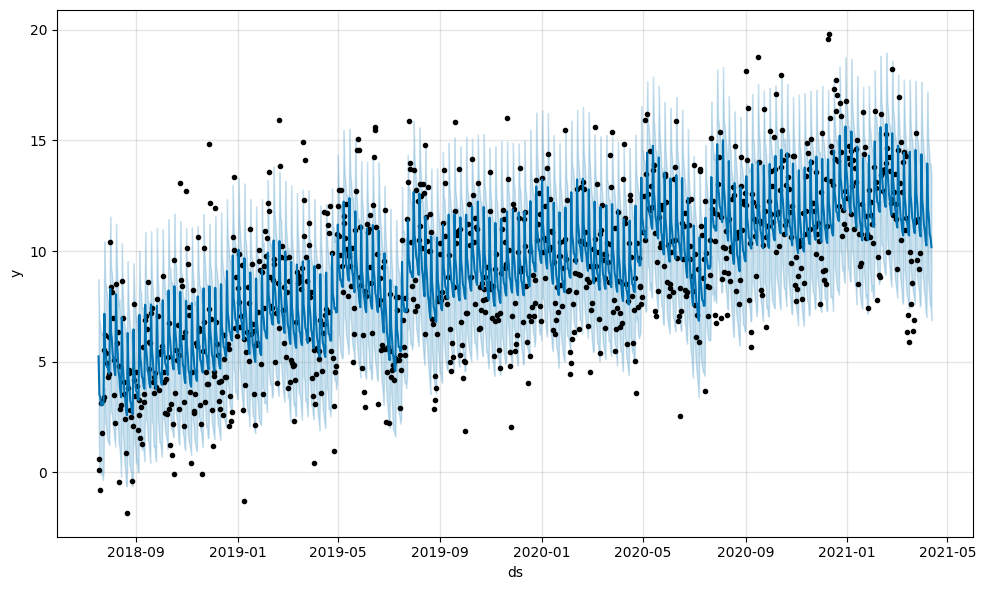

In [65]:
fig1 = m.plot(forecast)

Отобразим компоненты

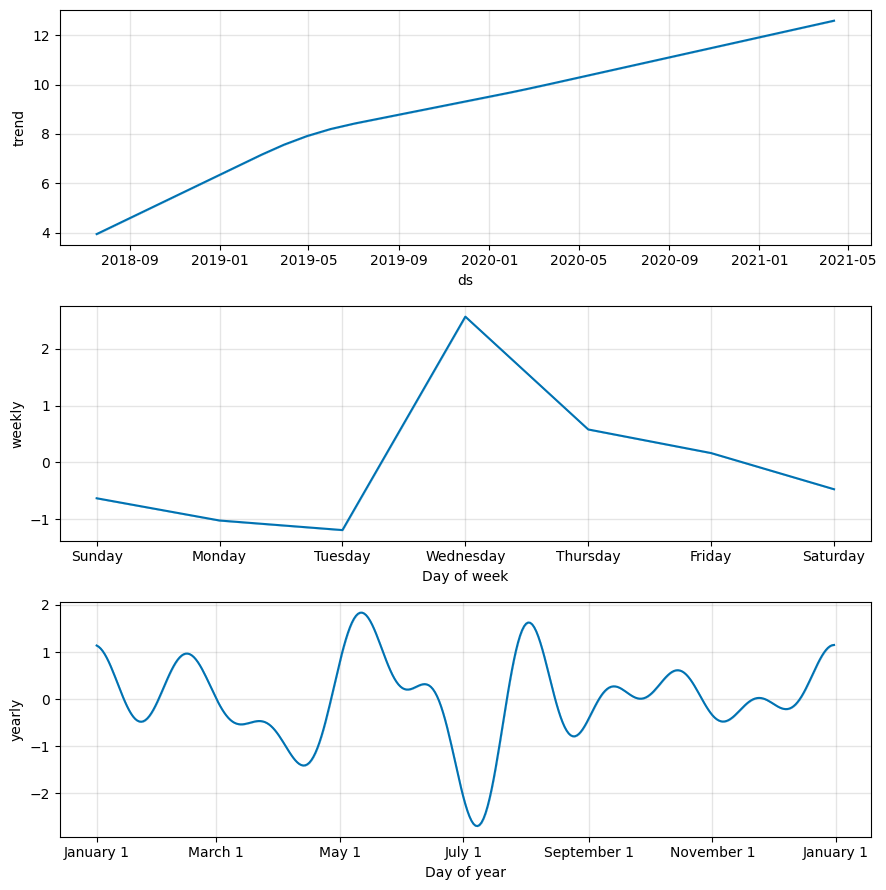

In [66]:
fig2 = m.plot_components(forecast)

Как и было мной получено при анализе, есть тренд глобальный, про недельную сезональность - она тоже есть, как и предполагалось, но теперь мы видим наглядно как она проявляется. Если бы было описание что за данные, можно было бы попредполагать, почепму пик приходится именно на среду, очень интересно.

In [67]:
data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')

# считаем ошибку
data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']


print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.34754872146810295


In [68]:
plotly_df(data_w_error.set_index('ds')[['y', 'yhat']], title = 'Fact and Forecast')

Очевидно мы не тюнили никак модельку, поэтому ничего ждать от нее не надо было, я хотел посмотреть сезональность покомпонентно. Исходя из такой недельной сезональности, надо видимо отбирать выборочно лаги, как я попытасля более менее модельку воссоздать выше (ARIMA).

**Далее будет две задачи. Вам надо выбрать одну. Если вы сделаете и 2.1, и 2.2, то будет выбран минимальный балл из двух**

## №2.1 (60 баллов)

- Не буду расписывать задание (как самый настоящий менеджер)
- На занятии вы разбирали данные о продажах Walmart для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview). Продолжим с ними работать.
- Вам необходимо сделать модель предсказания продаж в штате Висконсин (WI) категории Hobbies в целом (не углубляясь до торговых точек)
- Данные берем [отсюда](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

In [100]:
# Помните, что вам нужно выбрать нужные данные (штат Висконсин и категория Хобби)
# Получение и обработка исходных данных.

# Тренировочный датафрейм с проданными айтемами
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)

In [101]:
sales_train_evaluation

cat_id state_id variable  value
0          FOODS       CA      d_1  10101
1          FOODS       TX      d_1   6853
2          FOODS       WI      d_1   6224
3        HOBBIES       CA      d_1   1802
4        HOBBIES       TX      d_1    879
...          ...      ...      ...    ...
17464    HOBBIES       TX   d_1941   1543
17465    HOBBIES       WI   d_1941   1223
17466  HOUSEHOLD       CA   d_1941   6160
17467  HOUSEHOLD       TX   d_1941   3772
17468  HOUSEHOLD       WI   d_1941   3159

[17469 rows x 4 columns]

In [102]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [103]:
calendar

date       d  event_name_1 event_type_1  event_name_2   
0     2011-01-29     d_1           NaN          NaN           NaN  \
1     2011-01-30     d_2           NaN          NaN           NaN   
2     2011-01-31     d_3           NaN          NaN           NaN   
3     2011-02-01     d_4           NaN          NaN           NaN   
4     2011-02-02     d_5           NaN          NaN           NaN   
...          ...     ...           ...          ...           ...   
1964  2016-06-15  d_1965           NaN          NaN           NaN   
1965  2016-06-16  d_1966           NaN          NaN           NaN   
1966  2016-06-17  d_1967           NaN          NaN           NaN   
1967  2016-06-18  d_1968           NaN          NaN           NaN   
1968  2016-06-19  d_1969  NBAFinalsEnd     Sporting  Father's day   

     event_type_2  snap_CA  snap_TX  snap_WI  
0             NaN        0        0        0  
1             NaN        0        0        0  
2             NaN        0        0        0  
3             NaN        1        1        0  
4             NaN        1        0        1  
...           ...      ...      ...      ...  
1964          NaN        0        1        1  
1965          NaN        0        0        0  
1966          NaN        0        0        0  
1967          NaN        0        0        0  
1968     Cultural        0        0        0  

[1969 rows x 9 columns]

Смержим дни с календаря

In [104]:
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [105]:
sales_train_evaluation.head()

cat_id state_id    d      y        date
0    FOODS       CA  d_1  10101  2011-01-29
1    FOODS       TX  d_1   6853  2011-01-29
2    FOODS       WI  d_1   6224  2011-01-29
3  HOBBIES       CA  d_1   1802  2011-01-29
4  HOBBIES       TX  d_1    879  2011-01-29

Приведем данные к формату, требующемуся для Prophet

In [106]:
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [107]:
sales_train_evaluation.head()

ds state_id   cat_id      y
0  2011-01-29       CA    FOODS  10101
1  2011-01-29       TX    FOODS   6853
2  2011-01-29       WI    FOODS   6224
3  2011-01-29       CA  HOBBIES   1802
4  2011-01-29       TX  HOBBIES    879

In [108]:
# Выделим только данные по Висконсину
ca_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'WI', ['ds', 'cat_id', 'y']].copy()

In [109]:
# Для нашего примера поработаем только с категорией 'HOBBIES'

data = ca_data.loc[(ca_data.cat_id == 'HOBBIES')&(ca_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)

data_evaluation = ca_data.loc[(ca_data.cat_id == 'HOBBIES'),['ds', 'y']].copy().reset_index(drop = True)

In [110]:
plotly_df(data.set_index('ds'), title = 'WI HOBBIES')

- Что можете сказать?  


Явно есть годовая и недельная сезонность, также можно увидеть, что каждый год 25 декабря это значение равно нулю - это явно должно быть учтено в holidays. Про глобальный тренд сказать по графику нельзя, как будто есть, а как будто и незначимый.

In [111]:
# Попробуйте зафиттить базовую модель
m = fp.Prophet()

m.fit(data)

future = m.make_future_dataframe(periods=28)

forecast = m.predict(future)

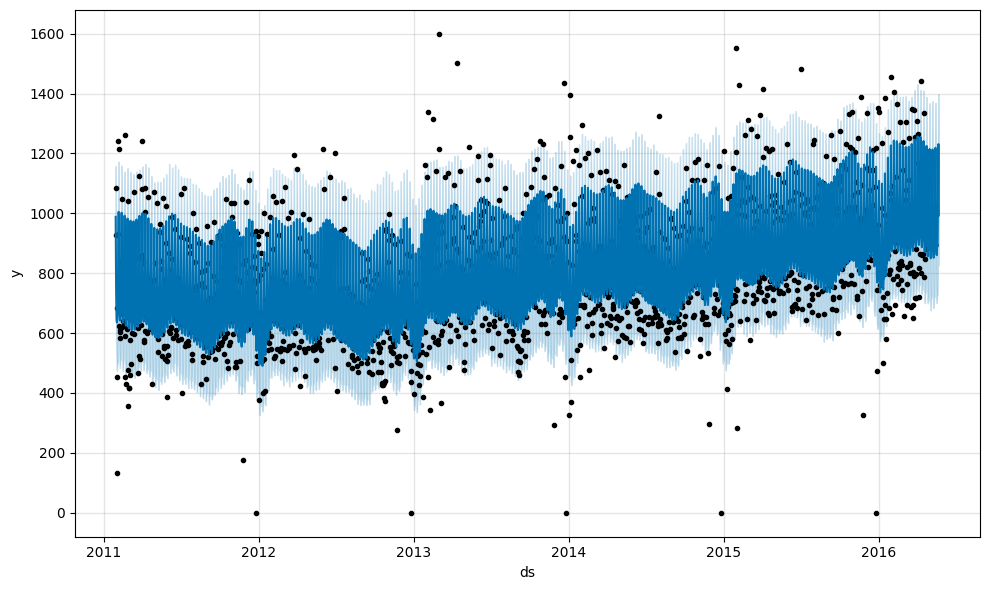

In [112]:
fig1 = m.plot(forecast)

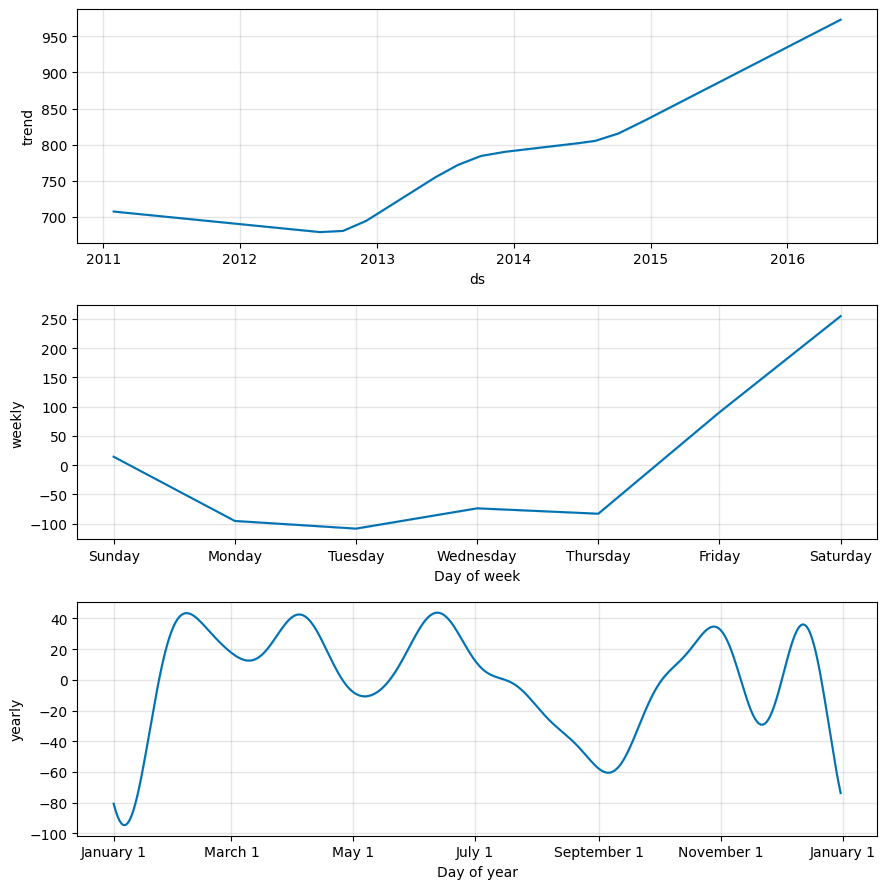

In [113]:
fig2 = m.plot_components(forecast)

In [115]:
data_evaluation['ds'] = pd.to_datetime(data_evaluation['ds'])
data['ds'] = pd.to_datetime(data['ds'])

data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')

data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']


print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.0837218938309133


In [116]:
plotly_df(data_w_error.set_index('ds')[['y', 'yhat']], title = 'Fact and Forecast')

- Что у вас получилось? 
- Что еще можете сказать, скажем, по поводу компонентов модели?


Как и ожидалось, моделька не реагирует на выбросы, но в целом хорошо предсказывает. 

По компонентам, мы видим явную недельную сезональность, в выходные она выходит на пик. Если анализировать годовую сезонность, мы видим, что весной и летом продажи на пике, также это просиходит перед зимним периодом видимо, а вот в остальные периоды есть просадка.

Также все-таки есть глобальный тренд, мои предположения сработали :)

- На занятии вам показывали 100500 параметров, с которыми можно поиграться, чтобы получить "лучшую" модель
- Во-первых, начнем с последнего, какзалось бы, шага. Какую метрику вы будете использовать? Почему?
- Каким именно способом вы будете проводить диагностику модели и сравнивать модели?
- Какие параметры вы будете менять? Почему? Попробуйте предположить, как именно необходимо поменять параметр модели, прежде чем приступать к тестированию. За неверное предположение баллы сниматься не будут при наличии обоснования.
- Как еще можно улучшить модель? Что можно добавить еще?

Я буду использовать ошибку MDAPE, так как нам нужно справляться с выбросами, которых в данном случае много. 

Сравнивать модели я буду с помощью кросс-валидации и усреднения ошибки.

Про параметры, я думаю стоит сначала поработать с параметрами про сезональность, так как дефолтная модель ее неправильно по моему мнению ставит, это надо проверить. 

In [117]:
# Функция для получения данных 'mdape', 'mape', 'mtape' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(fp_model):
    fp_df_cv = cross_validation(fp_model, initial='730.25 days', period='28 days', horizon = '28 days', parallel="processes")
    res = performance_metrics(fp_df_cv,rolling_window = 1)
    return res

In [118]:
pb_metrics_default = perf_metrics_28d(m)
pb_metrics_default

horizon           mse        rmse         mae     mdape    smape  coverage
0 28 days  19879.812621  140.995789  102.593631  0.097889  0.12765  0.812925

Выставим мультиплкативный параметр сезональности


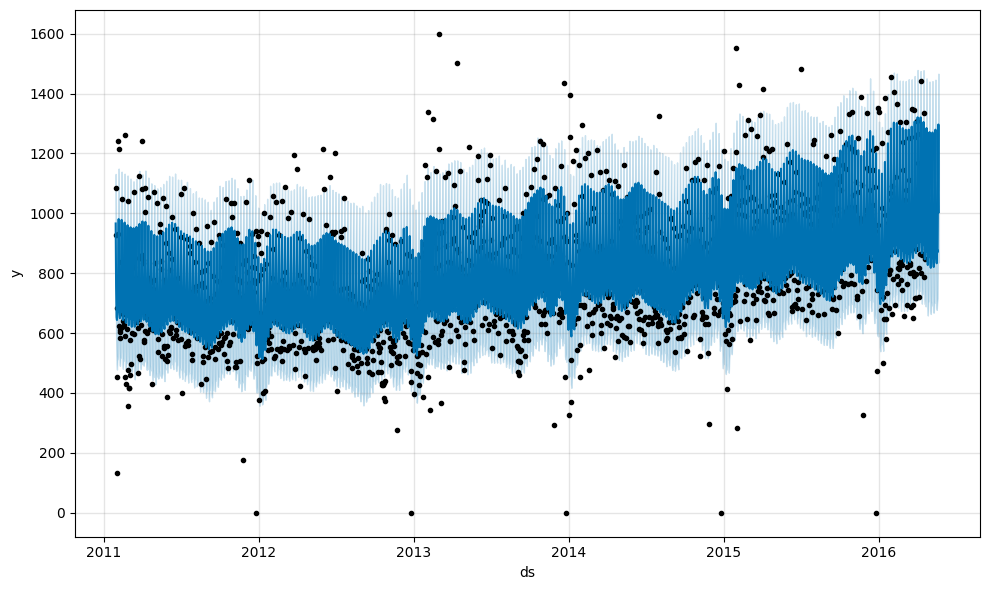

In [120]:
m_2_mult = fp.Prophet(
    seasonality_mode = 'multiplicative')

m_2_mult.fit(data)

future = m_2_mult.make_future_dataframe(periods=28)

forecast = m_2_mult.predict(future)
fig = m.plot(forecast)

In [140]:
pb_metrics_mult = perf_metrics_28d(m_2_mult)
pb_metrics_mult

horizon           mse        rmse        mae     mdape    smape  coverage
0 28 days  19994.479898  141.401838  103.11692  0.096239  0.12812  0.803571

MDAPE чутка снизилось

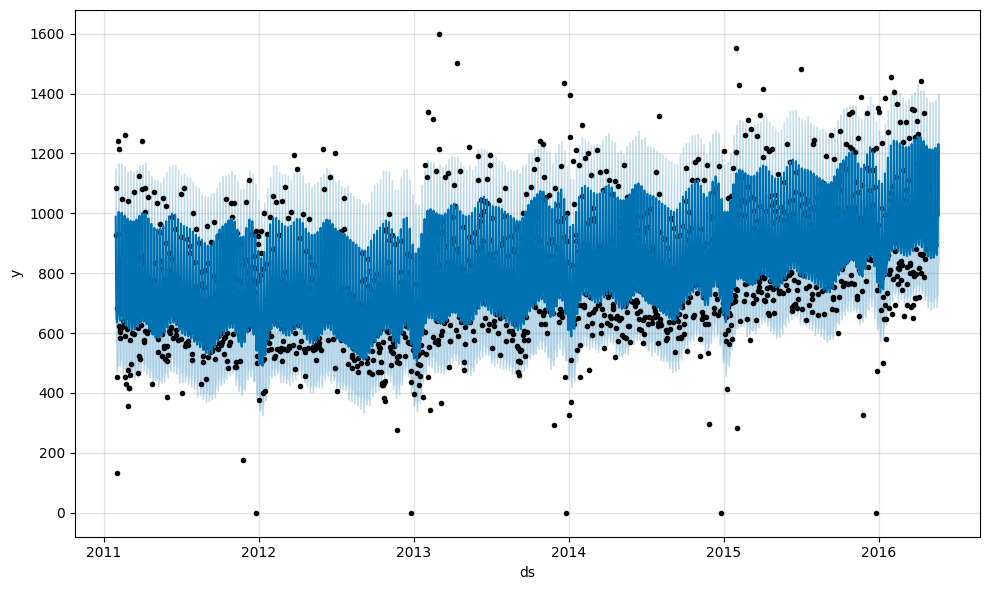

In [122]:
m_3_add = fp.Prophet(
    seasonality_mode = 'additive')

m_3_add.fit(data)

future = m_3_add.make_future_dataframe(periods=28)

forecast = m_3_add.predict(future)
fig = m.plot(forecast)

In [123]:
pb_metrics_add = perf_metrics_28d(m_3_add)
pb_metrics_add

horizon           mse        rmse         mae     mdape    smape  coverage
0 28 days  19879.812621  140.995789  102.593631  0.097889  0.12765  0.816327

MDAPE у мультипликативной поменьше

Углубимся в сезональность

In [130]:
ca_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'WI', ['ds', 'cat_id', 'y']].copy()
data_plot = ca_data.pivot(index='ds', columns='cat_id', values='y').reset_index()
data_plot['ds'] = pd.to_datetime(data_plot['ds'])
data_plot = data_plot.set_index('ds') 
data_plot_agg = data_plot.groupby(pd.Grouper(freq='M')).sum()

plotly_df(data_plot_agg[['HOBBIES']], title = 'WI HOBBIES items sold')

Годовой сезональности вообще нет, посмотрим если декомпозируем по неделям

In [131]:
ca_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'WI', ['ds', 'cat_id', 'y']].copy()
data_plot = ca_data.pivot(index='ds', columns='cat_id', values='y').reset_index()
data_plot['ds'] = pd.to_datetime(data_plot['ds'])
data_plot = data_plot.set_index('ds') 
data_plot_agg = data_plot.groupby(pd.Grouper(freq='W')).sum()

plotly_df(data_plot_agg[['HOBBIES']], title = 'WI HOBBIES items sold')

Тут уже как будто видно, что к концу года идет спад поработаем над параметрами для Фурье

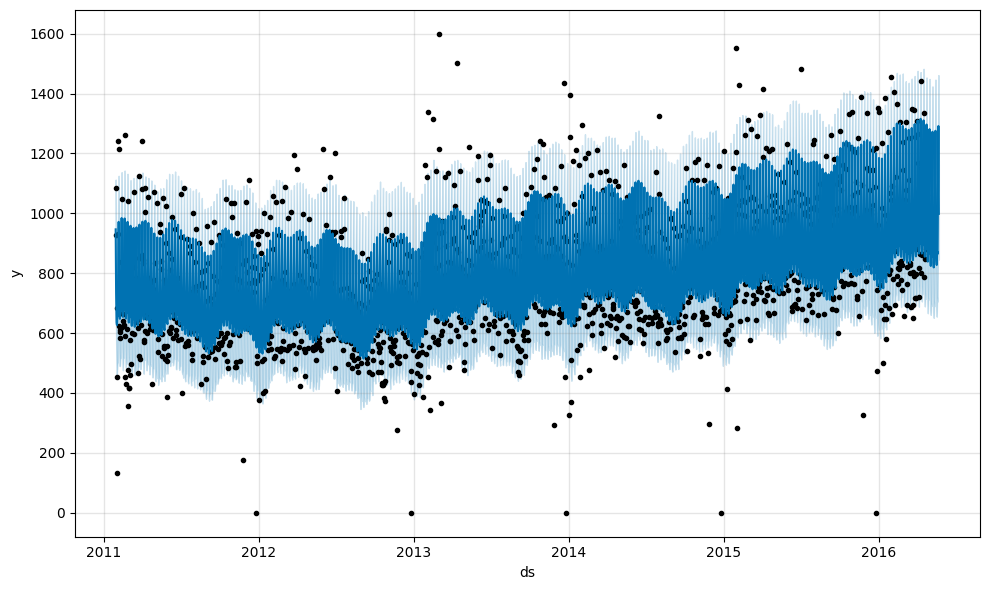

In [150]:
m_5 = fp.Prophet(
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_5.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')


m_5.fit(data)

future = m_5.make_future_dataframe(periods=28)

forecast = m_5.predict(future)
fig7 = m.plot(forecast)

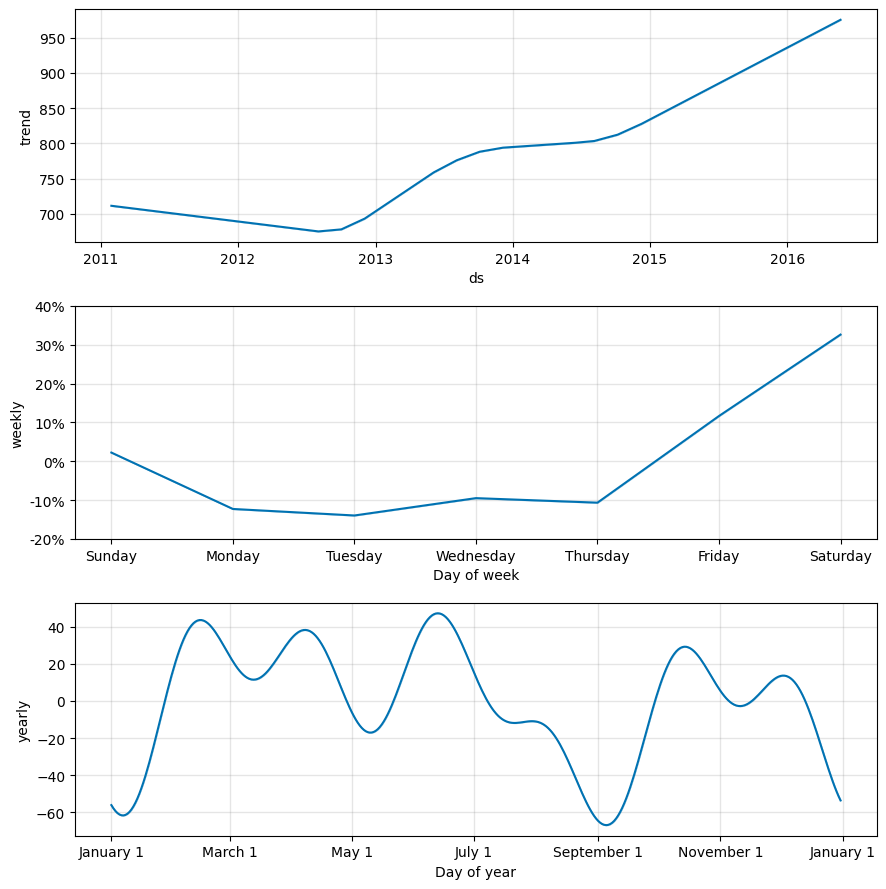

In [152]:
fig5 = m_5.plot_components(forecast)

In [151]:
pb_metrics_m_5 = perf_metrics_28d(m_5)
pb_metrics_m_5

horizon           mse        rmse         mae   mdape     smape  coverage
0 28 days  19370.302744  139.177235  100.787009  0.0934  0.125127   0.82483

In [141]:
pb_metrics_mult

horizon           mse        rmse        mae     mdape    smape  coverage
0 28 days  19994.479898  141.401838  103.11692  0.096239  0.12812  0.803571

Стало лучше на целых 3 тысячных, идем дальше

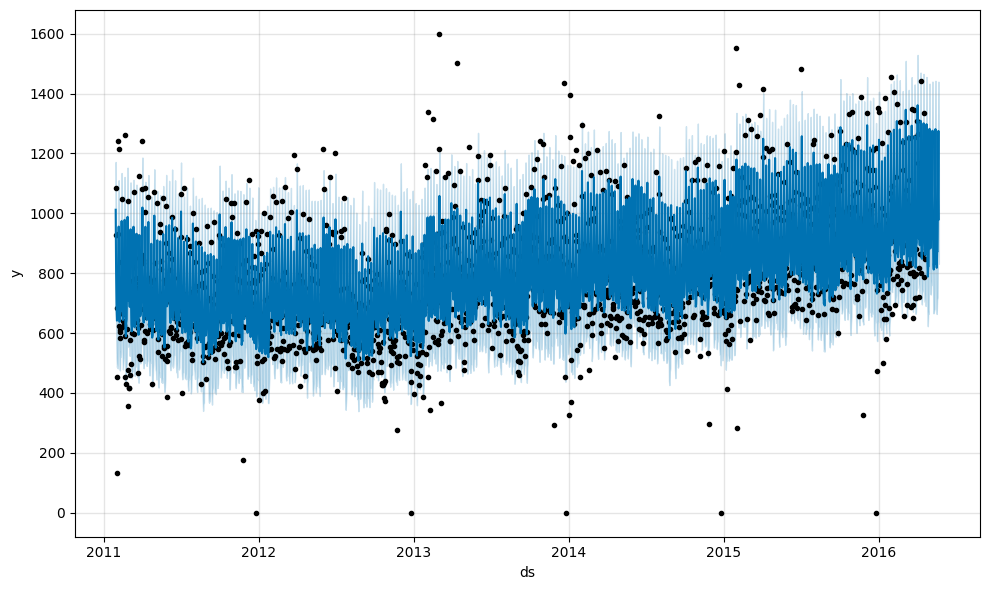

In [165]:
m_6 = fp.Prophet(
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False)

m_6.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')

m_6.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 7, 
                       mode = 'additive')

m_6.fit(data)

future = m_6.make_future_dataframe(periods=28)

forecast = m_6.predict(future)
fig8 = m.plot(forecast)

In [166]:
pb_metrics_m_6 = perf_metrics_28d(m_6)
pb_metrics_m_6

horizon           mse        rmse        mae    mdape     smape  coverage
0 28 days  18866.667511  137.355988  99.779433  0.09239  0.124099  0.803571

Подобрали оптималный параметр, отделив месячную сезональность, и получили меньшую ошибку

Подтюним все-таки тренд слегка, поиграемся с параметром changepoint_prior_scale, ниже представлен оптимальный по MDAPE параметр

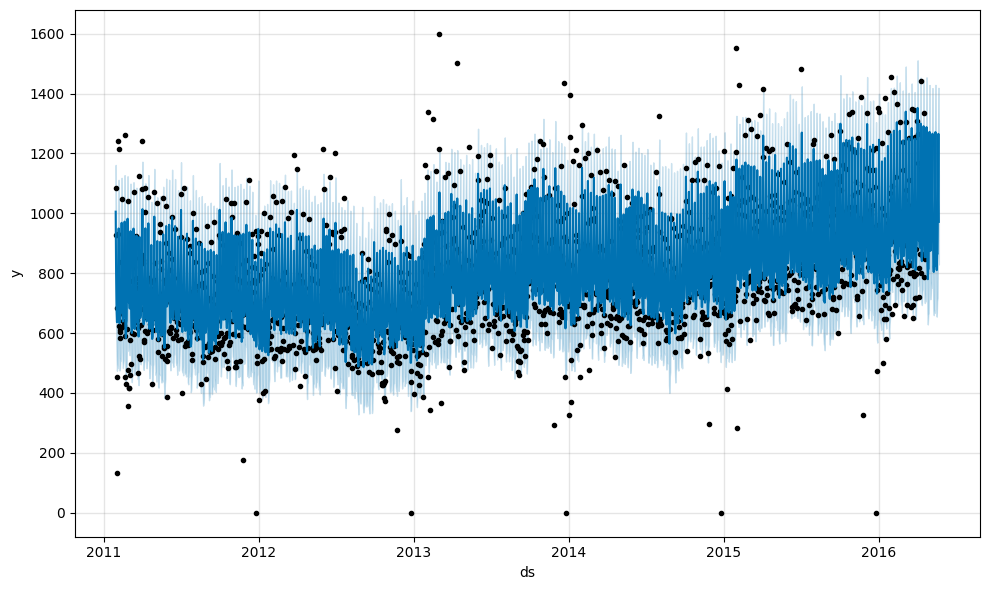

In [181]:
m_7 = fp.Prophet(
    seasonality_mode = 'multiplicative',
    changepoint_prior_scale=0.26,
    yearly_seasonality = False)

m_7.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')

m_7.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 7, 
                       mode = 'additive')

m_7.fit(data)

future = m_7.make_future_dataframe(periods=28)

forecast = m_7.predict(future)
fig8 = m.plot(forecast)

In [182]:
pb_metrics_m_7 = perf_metrics_28d(m_7)
pb_metrics_m_7

horizon          mse        rmse       mae     mdape     smape  coverage
0 28 days  18861.13704  137.335855  99.34227  0.089641  0.123603  0.798469

Учтем праздники, код доопределения праздников ниже я взял с лекции

In [183]:
import holidays

us_ca_holidays = holidays.UnitedStates(state='WI', years = [2011,2012,2013,2014,2015,2016,2017,2018], \
                                       observed = False)

holiday_df = pd.DataFrame.from_dict(us_ca_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

holiday          ds  lower_window  upper_window
0              New Year's Day  2011-01-01            -1             1
1  Martin Luther King Jr. Day  2011-01-17            -1             1
2             Valentine's Day  2011-02-14            -1             1
3        Susan B. Anthony Day  2011-02-15            -1             1
4       Washington's Birthday  2011-02-21            -1             1

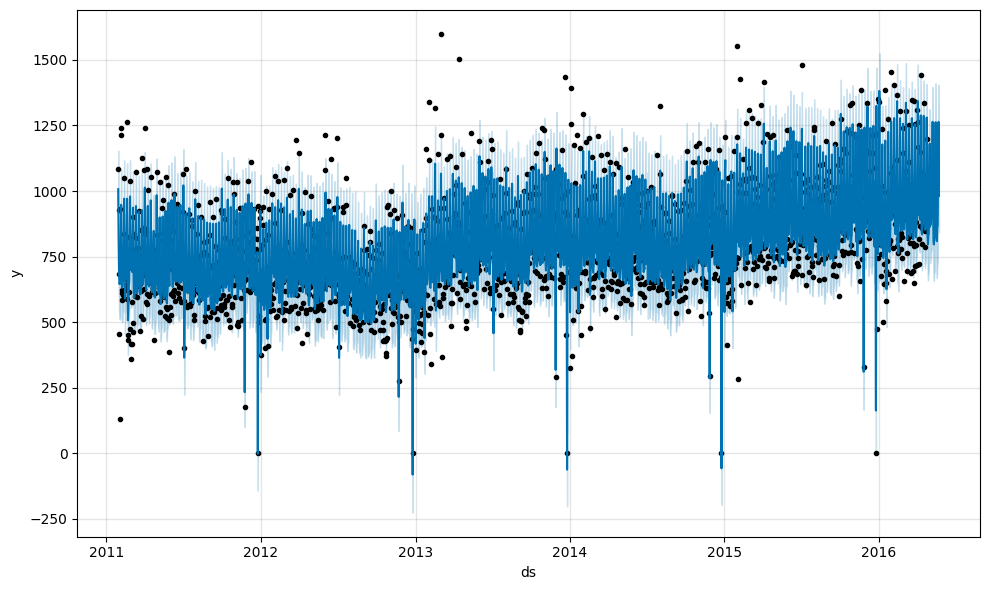

In [184]:
m_8 = fp.Prophet(
    changepoint_prior_scale=0.26,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df)

m_8.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')

m_8.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 7, 
                       mode = 'additive')


m_8.fit(data)

future = m_8.make_future_dataframe(periods=28)

forecast = m_8.predict(future)
fig7 = m_8.plot(forecast)

In [185]:
pb_metrics_m_8 = perf_metrics_28d(m_8)
pb_metrics_m_8

horizon          mse        rmse        mae     mdape     smape  coverage
0 28 days  16631.56305  128.963417  96.767671  0.089863  0.122096  0.761905

Но мы виидм, что у нас появляются отрицательные занчения - нехорошо..

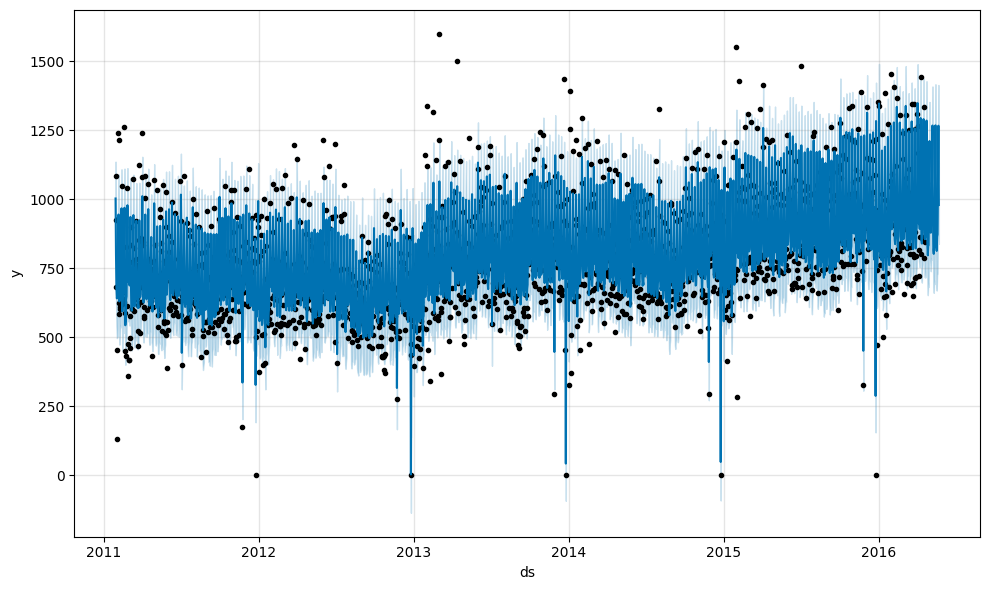

In [194]:
m_9 = fp.Prophet(
    changepoint_prior_scale=0.26,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df,
    holidays_prior_scale=0.1)

m_9.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')

m_9.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 7, 
                       mode = 'additive')


m_9.fit(data)

future = m_9.make_future_dataframe(periods=28)

forecast = m_9.predict(future)
fig7 = m_9.plot(forecast)

In [195]:
pb_metrics_m_9 = perf_metrics_28d(m_9)
pb_metrics_m_9

horizon           mse        rmse        mae     mdape     smape  coverage
0 28 days  16651.123049  129.039231  97.232572  0.089559  0.122536  0.772959

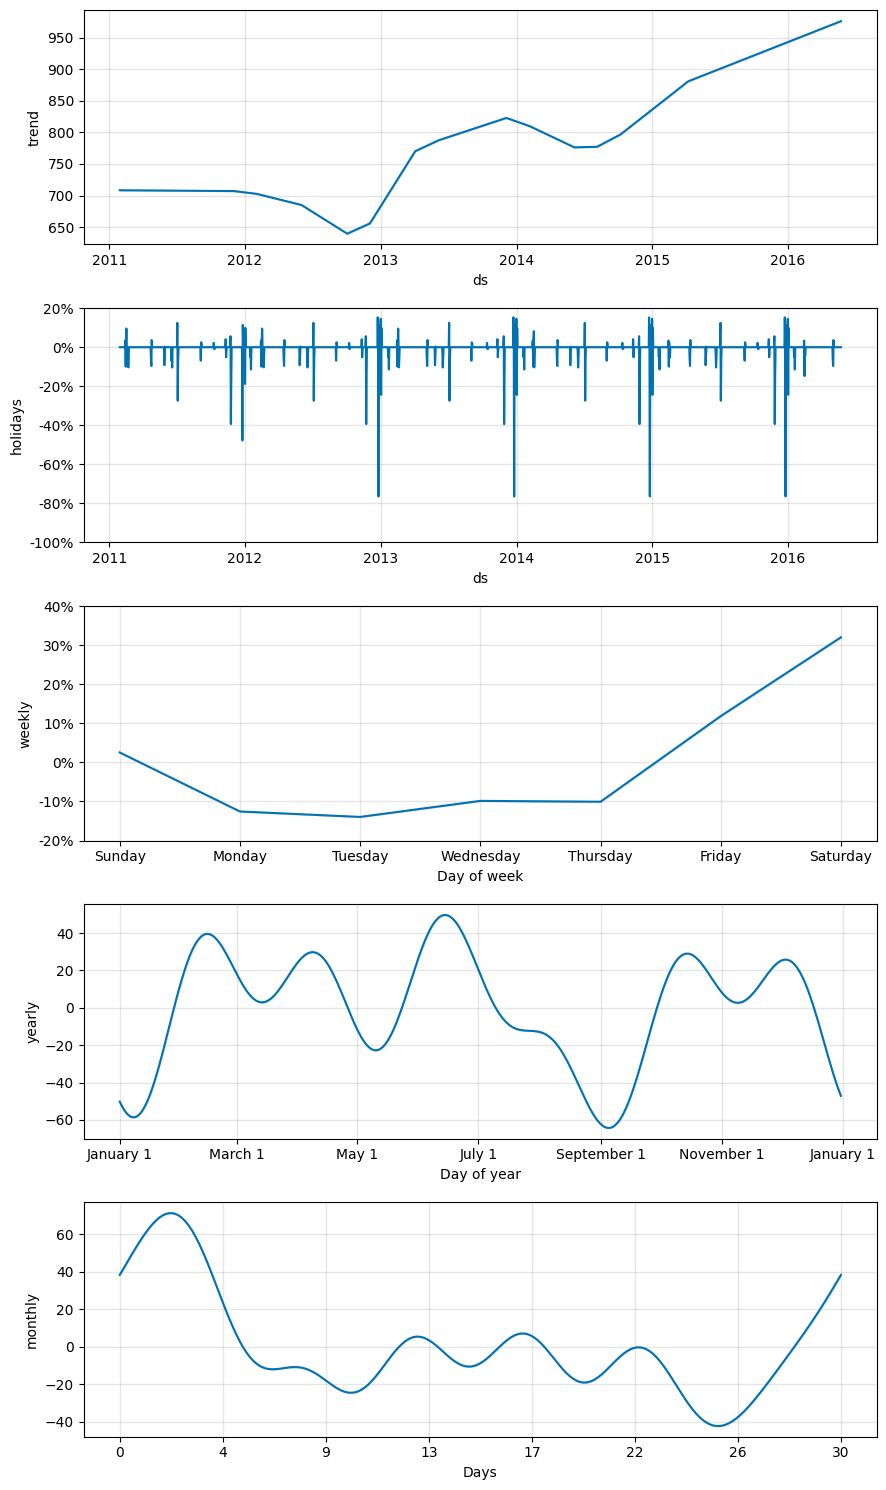

In [196]:
fig5 = m_9.plot_components(forecast)

Добавим регрессор из датасета calendar, а именно SNAP

In [200]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [201]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   d             1969 non-null   object
 2   event_name_1  162 non-null    object
 3   event_type_1  162 non-null    object
 4   event_name_2  5 non-null      object
 5   event_type_2  5 non-null      object
 6   snap_CA       1969 non-null   int64 
 7   snap_TX       1969 non-null   int64 
 8   snap_WI       1969 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 138.6+ KB


In [203]:
calendar['date'] = pd.to_datetime(calendar['date'])


In [204]:
data = data.merge(calendar[['date','snap_WI']], how = 'left', left_on='ds',
                                                      right_on = 'date')

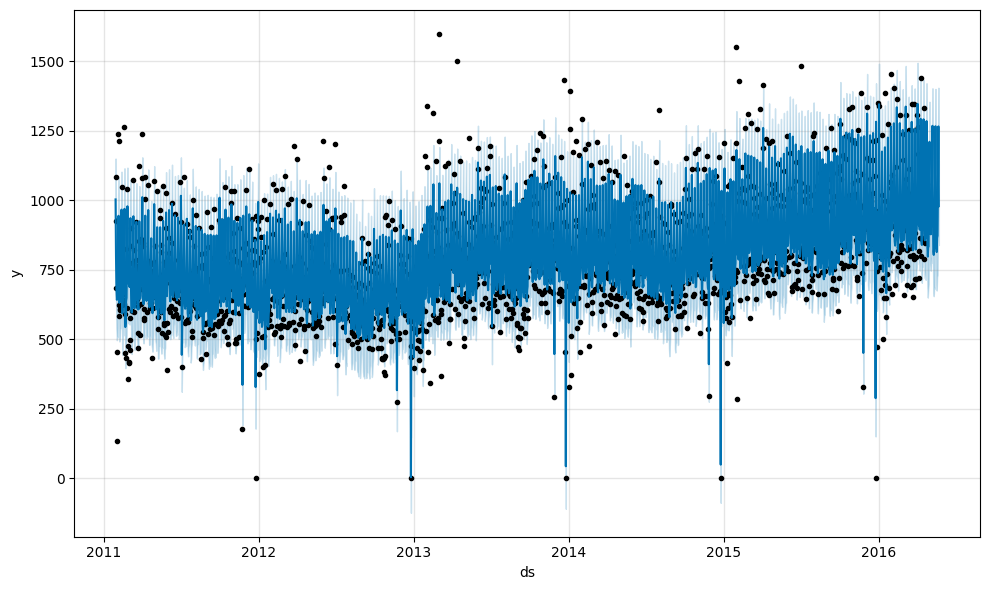

In [206]:
m_9 = fp.Prophet(
    changepoint_prior_scale=0.26,
    seasonality_mode = 'multiplicative',
    yearly_seasonality = False,
    holidays = holiday_df,
    holidays_prior_scale = 0.1)

m_9.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 6, 
                       mode = 'additive')

m_9.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 7, 
                       mode = 'additive')

# Добавляем регрессор до fit
m_9.add_regressor('snap_WI', mode='multiplicative')


m_9.fit(data)

future = m_9.make_future_dataframe(periods=28)
future['ds'] = pd.to_datetime(future['ds'])
future = future.merge(calendar[['date','snap_WI']], how = 'left', left_on='ds',
                                                      right_on = 'date')

forecast = m_9.predict(future)
figure = m_9.plot(forecast)

In [207]:
pb_metrics_m_9 = perf_metrics_28d(m_9)
pb_metrics_m_9

horizon           mse        rmse        mae     mdape    smape  coverage
0 28 days  16756.283228  129.446063  97.490764  0.091274  0.12286  0.764456

- А что если попробовать воспользоваться моделями другого класса? Давайте воспользуемся моделями класса [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html). Это обобщение класса SARIMA. Исопльзование внешних регрессоров не обязательно.
- Является временной ряд, с которым вы работаете стационарным? Тренд стационарым? Стационарным в разностях?
- Сколько лагов стоит использовать?

In [210]:
df_ar = data[['ds', 'y']]

Figure(640x480)
Figure(640x480)


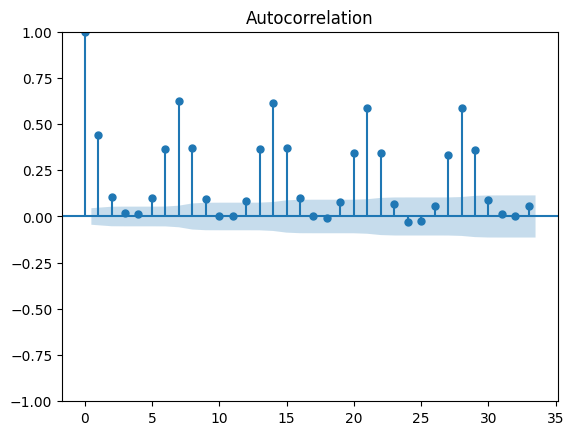

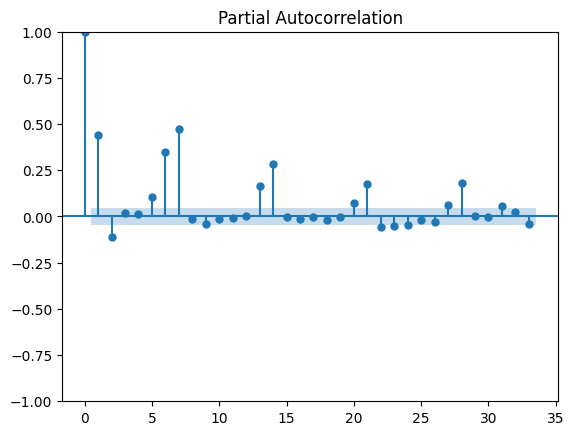

In [211]:
print(plot_acf(df_ar.y))
print(plot_pacf(df_ar.y))

Явно есть корреляция, недельная сезонность

In [212]:
adf_test(df_ar.y)

Results of Dickey-Fuller Test:
Test Statistic                   -3.021206
p-value                           0.032961
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64


In [213]:
kpss_test(df_ar.y)

Results of KPSS Test:
Test Statistic            8.153917
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Ну хоть adf нам говорит, что стационарность есть, но pvalue все таки не настолько маленькое, как это в kpss, так что вероятно ряд не стационарен

In [214]:
df_ar['y_diff'] = df_ar.y.diff().dropna()

Figure(640x480)
Figure(640x480)


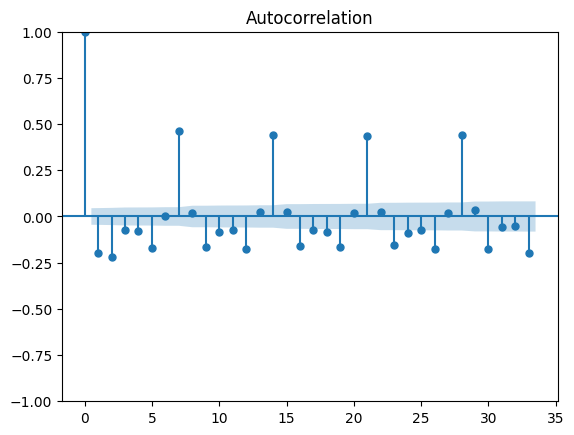

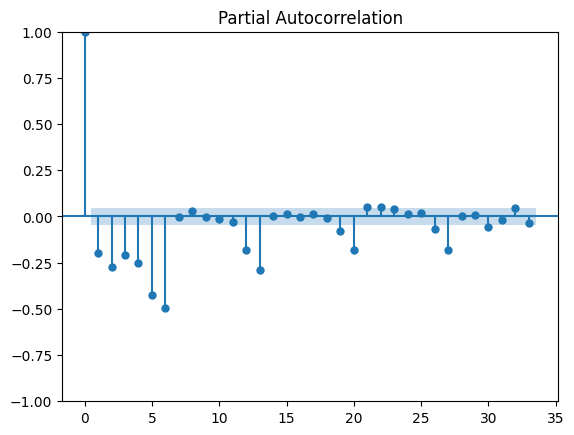

In [216]:
print(plot_acf(df_ar['y_diff'].dropna()))
print(plot_pacf(df_ar['y_diff'].dropna()))

In [217]:
print(adf_test(df_ar['y_diff'].dropna()),'\n')
print(kpss_test(df_ar['y_diff'].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -1.407652e+01
p-value                        2.878376e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64
None 

Results of KPSS Test:
Test Statistic            0.046148
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


Попробуем SARIMA

In [219]:
df_ar['y_diff_7'] = df_ar.y.diff().diff(7).dropna()
df_ar = df_ar.dropna()

Figure(640x480)
Figure(640x480)


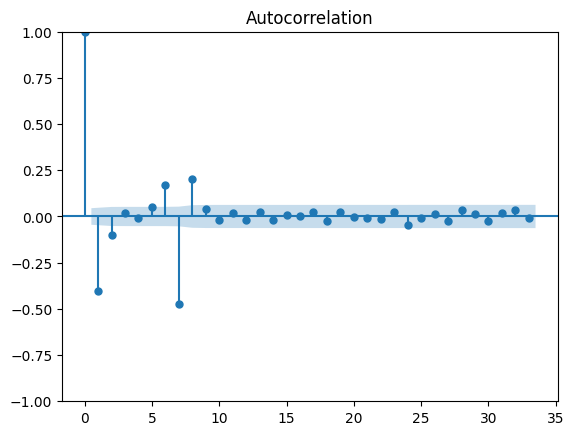

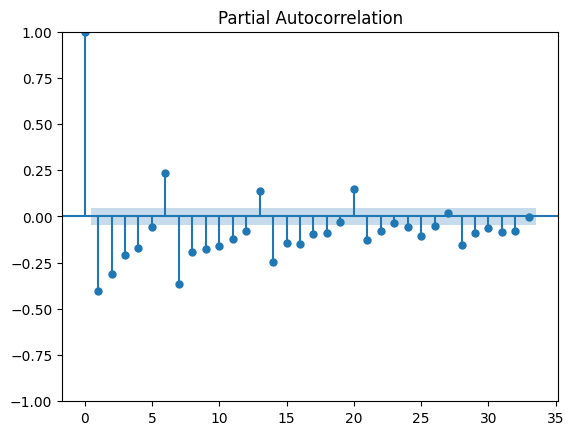

In [220]:
# Посмотрим еще раз на первоначальные данные
plotly_df(df_ar.set_index('ds')[['y_diff_7']])
print(plot_acf(df_ar[['y_diff_7']]))
print(plot_pacf(df_ar.set_index('ds')[['y_diff_7']]))

In [222]:
print(adf_test(df_ar.set_index('ds')[['y_diff_7']]),'\n')
print(kpss_test(df_ar.set_index('ds')[['y_diff_7']]))

Results of Dickey-Fuller Test:
Test Statistic                -1.470264e+01
p-value                        2.930267e-27
#Lags Used                     2.600000e+01
Number of Observations Used    1.878000e+03
Critical Value (1%)           -3.433837e+00
Critical Value (5%)           -2.863080e+00
Critical Value (10%)          -2.567590e+00
dtype: float64
None 

Results of KPSS Test:
Test Statistic            0.013948
p-value                   0.100000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


Подберем параметры автоаримой

In [226]:
import pmdarima as pm

model2 = pm.auto_arima(df_ar.y, #time series
                       d=1, # difference order
                       D=1, # seasonal difference order
                       max_p = 2,
                       max_q = 2,                       
                       information_criterion='aic', # used to select best mode
                       m=7, # number of periods in each season
                       max_P = 5,
                       start_Q = 0,
                       max_Q=0,
                       seasonal=True, # enable sasonal component
                       trace=True, # prints the information_criterion for each model it fits
                       error_action='ignore', # ignore orders that don't work
                       stepwise=True, # apply an intelligent order search
                       suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,0)[7]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=25799.141, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=24952.233, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=25460.468, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=24743.859, Time=0.58 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=24610.489, Time=0.80 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=24569.306, Time=1.67 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=24514.187, Time=2.01 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=24880.878, Time=0.85 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=24330.765, Time=3.47 sec
 ARIMA(2,1,0)(4,1,0)[7]             : AIC=24389.480, Time=1.77 sec
 ARIMA(2,1,1)(5,1,0)[7]             : AIC=inf, Time=11.02 sec
 ARIMA(1,1,1)(5,1,0)[7]             : AIC=inf, Time=8.36 sec
 ARIMA(2,1,0)(5,1,0)[7] intercept   : AIC=

In [227]:
%%time

best_arima = ARIMA(df_ar.y, order=(2, 1, 0), seasonal_order=(5,1,0,7))
best_arima =  best_arima.fit()
best_arima.summary()

CPU times: total: 3.73 s
Wall time: 3.49 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                               y   No. Observations:                 1905
Model:             ARIMA(2, 1, 0)x(5, 1, 0, 7)   Log Likelihood              -12157.383
Date:                         Fri, 14 Apr 2023   AIC                          24330.765
Time:                                 21:23:11   BIC                          24375.149
Sample:                                      0   HQIC                         24347.106
                                        - 1905                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5488      0.015    -35.981      0.000      -0.579      -0.519
ar.L2         -0.3060      0.018    -16.774      0.000      -0.342      -0.270
ar.S.L7       -0.7890      0.021    -37.228      0.000      -0.831      -0.747
ar.S.L14      -0.6238      0.025    -25.386      0.000      -0.672      -0.576
ar.S.L21      -0.4548      0.026    -17.253      0.000      -0.506      -0.403
ar.S.L28      -0.2692      0.025    -10.806      0.000      -0.318      -0.220
ar.S.L35      -0.1801      0.022     -8.266      0.000      -0.223      -0.137
sigma2      2.151e+04    402.038     53.491      0.000    2.07e+04    2.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.96   Jarque-Bera (JB):              2280.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Все парамтеры статзначимы, круто

In [228]:
forecast_sarima = best_arima.predict()
forecast_sarima


forecast_test_sarima = best_arima.forecast(28)

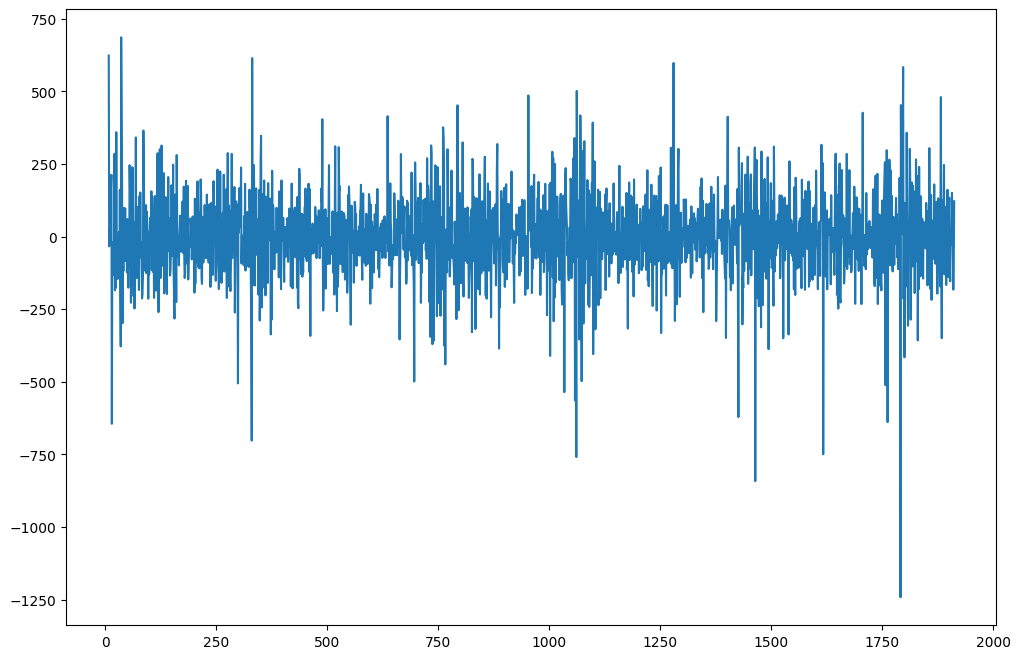

In [229]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid.plot()

Figure(640x480)
Figure(640x480)


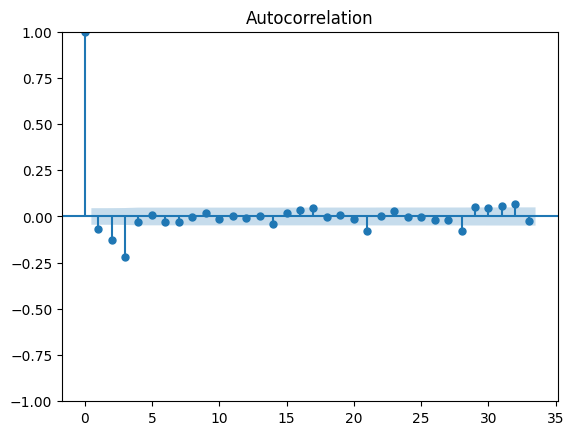

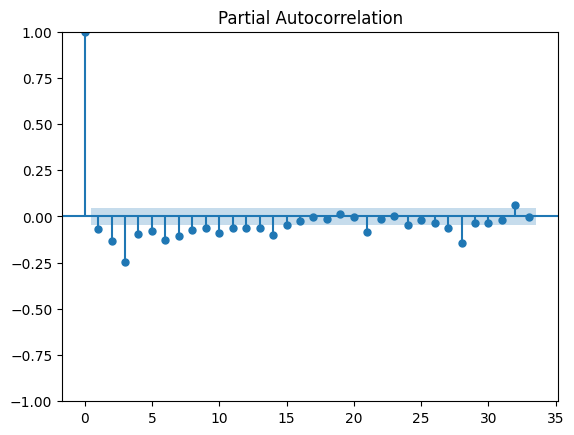

In [230]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [231]:
acorr_ljungbox(best_arima.resid, return_df=True)

lb_stat     lb_pvalue
1     8.121164  4.375145e-03
2    38.845653  3.670910e-09
3   132.465488  1.591177e-28
4   134.178806  4.971895e-28
5   134.289086  2.924427e-27
6   136.217905  6.291980e-27
7   138.075183  1.286097e-26
8   138.076759  5.958512e-26
9   138.686965  1.925470e-25
10  139.084101  6.492106e-25

Сравним модель с нашим Prophet

In [248]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
data_w_error = data.merge(forecast, how='left', on='ds')[['ds','y','yhat']]
resid_prophet = (data_w_error.y-data_w_error.yhat).dropna()[:-8]

In [250]:
resid_sarima = best_arima.resid.reset_index(drop=True)

dt = ((resid_prophet)**2-(resid_sarima)**2)

In [251]:
dt

0      -381754.622342
1        14304.738908
2         -732.373301
3        34868.142280
4       262340.851093
            ...      
1900       356.213406
1901      3105.009747
1902    -32136.754511
1903       826.764473
1904    -12956.308554
Length: 1905, dtype: float64

In [252]:
from scipy import stats
stats.ttest_1samp(dt, popmean=0, alternative='less')

TtestResult(statistic=-6.725040015754435, pvalue=1.1567196791191222e-11, df=1904)

Ttest сказал, что prophet круче 

- А теперь давайте сравним предсказания моделей двух классов.
- Каким тестом воспользуетесь?
- Какие у данного теста есть ограничения?
- Какую модель в итоге будете использовать?

Сравнение моделей произошло сверху, использовал DM тест, я не заметил этот пункт. Выбираем модельку с Prophet :) 

Я убрал оставшиеся задания, которые я не сделал, так как файлик не проходил ограничение по размеру на степике